In [40]:
import pandas as pd
import os
import numpy as np
import pickle
import string
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
import re

In [65]:
results_dir = '../results'
style_csv = 'style_feats_train.csv'
embs_csv = 'embs_all_train.csv'
proc_train_pkl = 'stanza_proc_train.pkl'

data_dir = "../data"
training_sets_dir = "haspeede2_dev"
training_file = "haspeede2_dev_taskAB.tsv"
badwords_txt = "lista_badwords.txt"

In [67]:
style_df = pd.read_csv(os.path.join(results_dir, style_csv), index_col=0)
embs_df = pd.read_csv(os.path.join(results_dir, embs_csv), index_col=0)
train_df = pd.read_table(os.path.join(data_dir, training_sets_dir, training_file), header= 0)
with open(os.path.join(results_dir, proc_train_pkl), 'rb') as infile:
    proc_train = pickle.load(infile)
with open(os.path.join(data_dir, badwords_txt), 'r') as infile:
    badwords = infile.readlines()
    badwords = set([word.replace('\n', '') for word in badwords])

Rapida estrazione dei lemmi mentre aspetto che Marco carichi la sua versione completa

In [11]:
%%time

custom_punctuation = string.punctuation + "’‘" + '’' + '' + '``' + "''" + '..' + '....' + '“”' + '…' + '«»' + '–' + '\\"'
token_list = list()
for row in proc_train:
    for sentence in row['proc_text'].sentences:
        for word in sentence.words:
            if word.lemma.lower() not in stopwords.words('italian') and word.lemma.lower() not in custom_punctuation:
                token_list.append(word.lemma.lower())
token_set = set([word for word, count in Counter(token_list).items() if count>=2])
token_df = []
for row in proc_train:
    token_row = {token: 0 for token in token_set}
    for sentence in row['proc_text'].sentences:
        for word in sentence.words:
            if word.lemma.lower() in token_set:
                token_row[word.lemma.lower()] += 1
    token_df.append(token_row)

token_df = pd.DataFrame(token_df)
token_df.shape

CPU times: total: 1min 5s
Wall time: 1min 6s


(6837, 5978)

In [39]:
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(token_df)
token_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=token_df.columns)

hashtags?

In [61]:
hashtag_re = re.compile(r'#([\w]+)')
texts = train_df['text '].values
ht_list = []
ht_rows = []

for tweet in texts:
    hts = [ht.lower() for ht in hashtag_re.findall(tweet)]
    ht_list += hts
    ht_rows.append(hts)
    
ht_set = set([ht for ht, count in Counter(ht_list).items() if count >= 2])
# we remove hashtags that are also lemmas (avrà senso?)
ht_set -= token_set

hashtag_df = []
for ht_list in ht_rows:
    row = {ht: 0 for ht in ht_set}
    for hashtag in ht_list:
        if hashtag in ht_set:
            row[hashtag] += 1
    hashtag_df.append(row)

hashtag_df = pd.DataFrame(hashtag_df)
hashtag_df.shape

(6837, 97)

badwords?

In [70]:
badwords_0_1 = []
for row in proc_train:
    counter = 0
    for sentence in row['proc_text'].sentences:
        for word in sentence.words:
            if word.lemma.lower() in badwords:
                counter += 1
    badwords_0_1.append(counter)
style_df['badwords_count'] = badwords_0_1

merge dfs

In [71]:
style_df.shape, embs_df.shape, token_tfidf_df.shape, hashtag_df.shape

((6837, 95), (6837, 128), (6837, 5978), (6837, 97))

In [72]:
style_df = style_df.reset_index(drop=True)
embs_df = embs_df.reset_index(drop=True)
token_tfidf_df = token_tfidf_df.reset_index(drop=True)
hashtag_df = hashtag_df.reset_index(drop=True)
train_df = pd.concat([style_df, embs_df, token_tfidf_df, hashtag_df], axis=1)
train_df.shape

(6837, 6298)

## model

In [89]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [75]:
train_X = train_df.drop(['hs', 'stereotype', 'raw_text'], axis=1)
train_y = train_df['hs']

In [91]:
# avevo fatto un po' di hyperparameter tuning

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', SVC(max_iter=5000, kernel='sigmoid', gamma=0.0001, degree=4, C=1000.0))
    ], verbose=True)

pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf',
                 SVC(C=1000.0, degree=4, gamma=0.0001, kernel='sigmoid',
                     max_iter=5000))],
         verbose=True)

In [81]:
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
    'f1_positive': make_scorer(f1_score, pos_label=1, zero_division=0)
}

In [83]:
%%time

scores = cross_validate(pipeline, train_X, train_y, scoring=scoring, cv=splitter)
print("Mean macro-f1:", np.mean(scores['test_f1_macro']).round(3))
print("Standard deviation macro-f1:", np.std(scores['test_f1_macro']).round(3))

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  46.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  47.9s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  49.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  48.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  48.0s
Mean macro-f1: 0.777
Standard deviation macro-f1: 0.008
CPU times: total: 5min
Wall time: 5min


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  49.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  49.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  49.7s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  51.8s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.4s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  54.6s


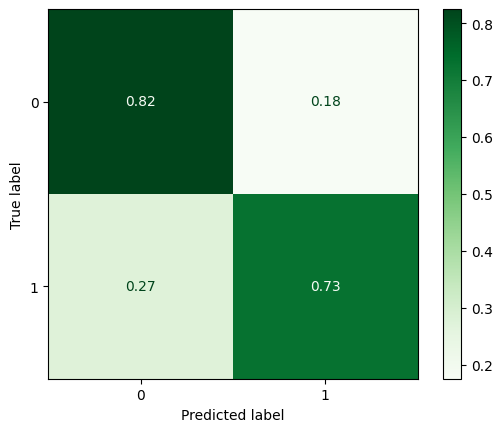

In [92]:
y_pred = cross_val_predict(pipeline, train_X, train_y, cv=splitter)
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=train_y, cmap='Greens', normalize='true')
plt.show()